This notebook is for grabbing all the eq positions right before forward or reverse annealing, and checking the dihedral distribution (i.e. are we getting only one rotamer)?

In [1]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from tqdm import tqdm
import argparse
import random
from simtk.openmm.app import Modeller


In [2]:
def get_dihedrals(i, phase, direction, outdir, htf, dihedral_indices_new, dihedral_indices_old):
    # Get topology with solute only
    modeller = Modeller(htf._topology_proposal.old_topology, htf.old_positions(htf.hybrid_positions))
    modeller.deleteWater()
    old_top = md.Topology.from_openmm(modeller.topology)
    
    modeller = Modeller(htf._topology_proposal.new_topology, htf.new_positions(htf.hybrid_positions))
    modeller.deleteWater()
    new_top = md.Topology.from_openmm(modeller.topology)
    
    # Get last positions from eq positions of each cycle (positions are solute only)
    from tqdm import tqdm
#     all_pos_old = np.zeros(shape=(100, old_top.n_atoms, 3))
#     all_pos_new = np.zeros(shape=(100, new_top.n_atoms, 3))
    all_pos_old = []
    all_pos_new = []
    for j in tqdm(range(100)):
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_{direction}_eq_old.npy"), "rb") as f:
#                 all_pos_old[j] = np.load(f)[-1]
                all_pos_old.append(np.load(f)[-1])
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_{direction}_eq_new.npy"), "rb") as f:
#                 all_pos_new[j] = np.load(f)[-1]
                all_pos_new.append(np.load(f)[-1])
        except FileNotFoundError:
            pass
    print(f"old files found: {len(all_pos_old)}")
    print(f"new files found: {len(all_pos_new)}")
    
    # Compute dihedrals
    traj = md.Trajectory(np.array(all_pos_old), old_top)
    dihedrals_old = md.compute_dihedrals(traj, np.array([dihedral_indices_old]))
    
    traj = md.Trajectory(np.array(all_pos_new), new_top)
    dihedrals_new = md.compute_dihedrals(traj, np.array([dihedral_indices_new]))
    
    return dihedrals_new, dihedrals_old

def get_dihedrals_from_hybrid(i, phase, endstate, outdir, htf, dihedral_indices_new, dihedral_indices_old):
    # Get topology 
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    
    # Read hybrid positions
    with open(os.path.join(outdir, f"{i}_{phase}_equil_hybrid_{endstate}_20ns.npy"), "rb") as f:
        hybrid_pos = np.load(f)
    
    # Get the old and new positions from the hybrid positions
    from tqdm import tqdm
    n_frames = hybrid_pos.shape[0]
    all_pos_old = np.zeros(shape=(n_frames, old_top.n_atoms, 3))
    all_pos_new = np.zeros(shape=(n_frames, new_top.n_atoms, 3))
    for j in tqdm(range(n_frames)):
#         all_pos_old[j] = htf.old_positions(hybrid_pos[j]*unit.nanometers)
        all_pos_new[j] = htf.new_positions(hybrid_pos[j]*unit.nanometers)

    # Compute dihedrals
    traj = md.Trajectory(np.array(all_pos_old), old_top)
    dihedrals_old = md.compute_dihedrals(traj, np.array([dihedral_indices_old]))
    
    traj = md.Trajectory(np.array(all_pos_new), new_top)
    dihedrals_new = md.compute_dihedrals(traj, np.array([dihedral_indices_new]))
    
    return dihedrals_new, dihedrals_old


def plot_dihedrals(dihedrals, outfile):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals)
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
    plt.show()
#     plt.savefig(outfile, dpi=300)
    plt.close()



# Check dihedrals of THR for apo T42A neq switching (before running annealing) 

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/31/"
phase = "apo"
i = os.path.basename(os.path.dirname(outdir))


In [4]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [5]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)>
<Atom 1 (C) of chain 0 residue 0 (ACE)>
<Atom 2 (O) of chain 0 residue 0 (ACE)>
<Atom 3 (H1) of chain 0 residue 0 (ACE)>
<Atom 4 (H2) of chain 0 residue 0 (ACE)>
<Atom 5 (H3) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (LYS)>
<Atom 7 (CA) of chain 0 residue 1 (LYS)>
<Atom 8 (C) of chain 0 residue 1 (LYS)>
<Atom 9 (O) of chain 0 residue 1 (LYS)>
<Atom 10 (CB) of chain 0 residue 1 (LYS)>
<Atom 11 (CG) of chain 0 residue 1 (LYS)>
<Atom 12 (CD) of chain 0 residue 1 (LYS)>
<Atom 13 (CE) of chain 0 residue 1 (LYS)>
<Atom 14 (NZ) of chain 0 residue 1 (LYS)>
<Atom 15 (H2) of chain 0 residue 1 (LYS)>
<Atom 16 (HA) of chain 0 residue 1 (LYS)>
<Atom 17 (HB3) of chain 0 residue 1 (LYS)>
<Atom 18 (HB2) of chain 0 residue 1 (LYS)>
<Atom 19 (HG2) of chain 0 residue 1 (LYS)>
<Atom 20 (HG3) of chain 0 residue 1 (LYS)>
<Atom 21 (HD2) of chain 0 residue 1 (LYS)>
<Atom 22 (HD3) of chain 0 residue 1 (LYS)>
<Atom 23 (HE3) of chain 0 residue 1 (LYS)>

<Atom 3463 (O) of chain 2 residue 765 (HOH)>
<Atom 3464 (H1) of chain 2 residue 765 (HOH)>
<Atom 3465 (H2) of chain 2 residue 765 (HOH)>
<Atom 3466 (O) of chain 2 residue 766 (HOH)>
<Atom 3467 (H1) of chain 2 residue 766 (HOH)>
<Atom 3468 (H2) of chain 2 residue 766 (HOH)>
<Atom 3469 (O) of chain 2 residue 767 (HOH)>
<Atom 3470 (H1) of chain 2 residue 767 (HOH)>
<Atom 3471 (H2) of chain 2 residue 767 (HOH)>
<Atom 3472 (O) of chain 2 residue 768 (HOH)>
<Atom 3473 (H1) of chain 2 residue 768 (HOH)>
<Atom 3474 (H2) of chain 2 residue 768 (HOH)>
<Atom 3475 (O) of chain 2 residue 769 (HOH)>
<Atom 3476 (H1) of chain 2 residue 769 (HOH)>
<Atom 3477 (H2) of chain 2 residue 769 (HOH)>
<Atom 3478 (O) of chain 2 residue 770 (HOH)>
<Atom 3479 (H1) of chain 2 residue 770 (HOH)>
<Atom 3480 (H2) of chain 2 residue 770 (HOH)>
<Atom 3481 (O) of chain 2 residue 771 (HOH)>
<Atom 3482 (H1) of chain 2 residue 771 (HOH)>
<Atom 3483 (H2) of chain 2 residue 771 (HOH)>
<Atom 3484 (O) of chain 2 residue 772 (HO

<Atom 6963 (H2) of chain 2 residue 1931 (HOH)>
<Atom 6964 (O) of chain 2 residue 1932 (HOH)>
<Atom 6965 (H1) of chain 2 residue 1932 (HOH)>
<Atom 6966 (H2) of chain 2 residue 1932 (HOH)>
<Atom 6967 (O) of chain 2 residue 1933 (HOH)>
<Atom 6968 (H1) of chain 2 residue 1933 (HOH)>
<Atom 6969 (H2) of chain 2 residue 1933 (HOH)>
<Atom 6970 (O) of chain 2 residue 1934 (HOH)>
<Atom 6971 (H1) of chain 2 residue 1934 (HOH)>
<Atom 6972 (H2) of chain 2 residue 1934 (HOH)>
<Atom 6973 (O) of chain 2 residue 1935 (HOH)>
<Atom 6974 (H1) of chain 2 residue 1935 (HOH)>
<Atom 6975 (H2) of chain 2 residue 1935 (HOH)>
<Atom 6976 (O) of chain 2 residue 1936 (HOH)>
<Atom 6977 (H1) of chain 2 residue 1936 (HOH)>
<Atom 6978 (H2) of chain 2 residue 1936 (HOH)>
<Atom 6979 (O) of chain 2 residue 1937 (HOH)>
<Atom 6980 (H1) of chain 2 residue 1937 (HOH)>
<Atom 6981 (H2) of chain 2 residue 1937 (HOH)>
<Atom 6982 (O) of chain 2 residue 1938 (HOH)>
<Atom 6983 (H1) of chain 2 residue 1938 (HOH)>
<Atom 6984 (H2) of c

<Atom 10962 (H2) of chain 2 residue 3264 (HOH)>
<Atom 10963 (O) of chain 2 residue 3265 (HOH)>
<Atom 10964 (H1) of chain 2 residue 3265 (HOH)>
<Atom 10965 (H2) of chain 2 residue 3265 (HOH)>
<Atom 10966 (O) of chain 2 residue 3266 (HOH)>
<Atom 10967 (H1) of chain 2 residue 3266 (HOH)>
<Atom 10968 (H2) of chain 2 residue 3266 (HOH)>
<Atom 10969 (O) of chain 2 residue 3267 (HOH)>
<Atom 10970 (H1) of chain 2 residue 3267 (HOH)>
<Atom 10971 (H2) of chain 2 residue 3267 (HOH)>
<Atom 10972 (O) of chain 2 residue 3268 (HOH)>
<Atom 10973 (H1) of chain 2 residue 3268 (HOH)>
<Atom 10974 (H2) of chain 2 residue 3268 (HOH)>
<Atom 10975 (O) of chain 2 residue 3269 (HOH)>
<Atom 10976 (H1) of chain 2 residue 3269 (HOH)>
<Atom 10977 (H2) of chain 2 residue 3269 (HOH)>
<Atom 10978 (O) of chain 2 residue 3270 (HOH)>
<Atom 10979 (H1) of chain 2 residue 3270 (HOH)>
<Atom 10980 (H2) of chain 2 residue 3270 (HOH)>
<Atom 10981 (O) of chain 2 residue 3271 (HOH)>
<Atom 10982 (H1) of chain 2 residue 3271 (HOH)>

### Forward

In [6]:
indices_old = [669, 670, 673, 674]
indices_new = [669, 670, 673, 676]
dihedrals_new, dihedrals_old = get_dihedrals(i, phase, 'forward', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


old files found: 100
new files found: 100


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

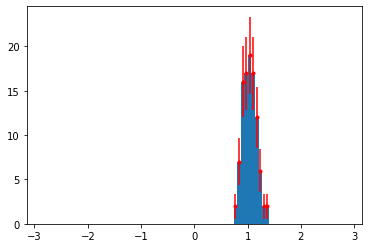

In [7]:
plot_dihedrals(dihedrals_old, os.path.join(outdir, f"correlated.png"))


### Reverse

In [8]:
indices_old = [669, 670, 673, 674]
indices_new = [669, 670, 673, 676]
dihedrals_new, dihedrals_old = get_dihedrals(i, phase, 'reverse', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:06<00:00, 16.10it/s]

old files found: 100
new files found: 100


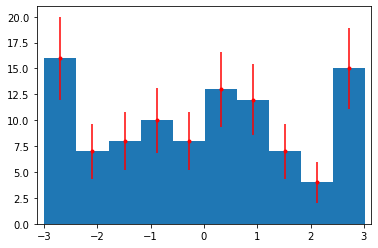

In [9]:
plot_dihedrals(dihedrals_old, os.path.join(outdir, f"correlated.png"))


# Check dihedrals of THR for apo A42T neq switching (before running annealing) 

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/32/"
phase = "apo"
i = os.path.basename(os.path.dirname(outdir))


In [4]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [29]:
htf.hybrid_system.getForces()

[<simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2baa12e68960> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2baa12e68ed0> >,
 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2baa12e68a80> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2baa12e68a50> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2baa12b71ed0> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2bab6ce54b70> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2bab6ce54bd0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2bab6ce54c30> >,
 <simtk.openmm.o

In [32]:
htf._atom_classes['unique_old_atoms']

{673, 676, 677, 678}

In [33]:
htf._atom_classes['unique_new_atoms']

{14873, 14874, 14875, 14876, 14877, 14878, 14879, 14880}

In [40]:
torsion_force = htf.hybrid_system.getForce(5)
for i in range(torsion_force.getNumTorsions()):
    p1, p2, p3, p4, params = torsion_force.getTorsionParameters(i)
    if set([p1, p2, p3, p4]).intersection(htf._atom_classes['unique_old_atoms']) != set():
        print(p1, p2, p3, p4, params)

652 669 670 673 (3.0, 0.0, 3.3472000000000004, 3.0, 0.0, 0.0)
652 669 670 673 (2.0, 0.0, 7.5312, 2.0, 0.0, 0.0)
652 669 670 673 (1.0, 0.0, 8.368, 1.0, 0.0, 0.0)
669 670 673 676 (3.0, 0.0, 0.6508444444444444, 3.0, 0.0, 0.0)
669 670 673 677 (3.0, 0.0, 0.6508444444444444, 3.0, 0.0, 0.0)
669 670 673 678 (3.0, 0.0, 0.6508444444444444, 3.0, 0.0, 0.0)
671 670 673 676 (3.0, 0.0, 0.6508444444444444, 3.0, 0.0, 0.0)
671 670 673 677 (3.0, 0.0, 0.6508444444444444, 3.0, 0.0, 0.0)
671 670 673 678 (3.0, 0.0, 0.6508444444444444, 3.0, 0.0, 0.0)
673 670 671 679 (3.0, 0.0, 1.6736000000000002, 3.0, 0.0, 0.0)
673 670 671 679 (2.0, 0.0, 0.8368000000000001, 2.0, 0.0, 0.0)
673 670 671 679 (1.0, 0.0, 0.8368000000000001, 1.0, 0.0, 0.0)
675 670 673 676 (3.0, 0.0, 0.6508444444444444, 3.0, 0.0, 0.0)
675 670 673 677 (3.0, 0.0, 0.6508444444444444, 3.0, 0.0, 0.0)
675 670 673 678 (3.0, 0.0, 0.6508444444444444, 3.0, 0.0, 0.0)


In [43]:
nb_excep_force = htf.hybrid_system.getForce(9)
for i in range(nb_excep_force.getNumBonds()):
    p1, p2, params = nb_excep_force.getBondParameters(i)
    if set([p1, p2]).intersection(htf._atom_classes['unique_new_atoms']) != set():
        print(nb_excep_force.getBondParameters(i))

[652, 14873, (0.18187785000000004, 0.3399669508423535, 0.0, 0.3399669508423535, 0.20291752979375635, 0.0, 1.0)]
[672, 14873, (-0.17292555, 0.3179795704786499, 0.0, 0.3179795704786499, 0.3170881327580709, 0.0, 1.0)]
[14873, 674, (0.08279355, 0.2234373985095971, 0.0, 0.2234373985095971, 0.08670021359327784, 0.0, 1.0)]
[669, 14874, (-0.001489591666666667, 0.28606757839486296, 0.0, 0.28606757839486296, 0.10807766844265286, 0.0, 1.0)]
[671, 14874, (0.002140325, 0.2935511276272418, 0.0, 0.2935511276272418, 0.07687068162049819, 0.0, 1.0)]
[675, 14874, (0.0003608416666666667, 0.2471353044121301, 0.0, 0.2471353044121301, 0.032844399999999996, 0.0, 1.0)]
[669, 14875, (0.08445638333333334, 0.3324834016099747, 0.0, 0.3324834016099747, 0.28529542140034425, 0.0, 1.0)]
[671, 14875, (-0.12135145000000001, 0.3399669508423535, 0.0, 0.3399669508423535, 0.20291752979375635, 0.0, 1.0)]
[675, 14875, (-0.020458883333333334, 0.2935511276272418, 0.0, 0.2935511276272418, 0.08670021359327784, 0.0, 1.0)]
[670, 14

In [46]:
for atom in htf.hybrid_topology.atoms:
    print(atom.index, atom)

0 ACE0-CH3
1 ACE0-C
2 ACE0-O
3 ACE0-H1
4 ACE0-H2
5 ACE0-H3
6 LYS1-N
7 LYS1-CA
8 LYS1-C
9 LYS1-O
10 LYS1-CB
11 LYS1-CG
12 LYS1-CD
13 LYS1-CE
14 LYS1-NZ
15 LYS1-H2
16 LYS1-HA
17 LYS1-HB3
18 LYS1-HB2
19 LYS1-HG2
20 LYS1-HG3
21 LYS1-HD2
22 LYS1-HD3
23 LYS1-HE3
24 LYS1-HE2
25 LYS1-HZ1
26 LYS1-HZ2
27 LYS1-HZ3
28 LYS2-N
29 LYS2-CA
30 LYS2-C
31 LYS2-O
32 LYS2-CB
33 LYS2-CG
34 LYS2-CD
35 LYS2-CE
36 LYS2-NZ
37 LYS2-H
38 LYS2-HA
39 LYS2-HB3
40 LYS2-HB2
41 LYS2-HG2
42 LYS2-HG3
43 LYS2-HD3
44 LYS2-HD2
45 LYS2-HE3
46 LYS2-HE2
47 LYS2-HZ1
48 LYS2-HZ2
49 LYS2-HZ3
50 ALA3-N
51 ALA3-CA
52 ALA3-C
53 ALA3-O
54 ALA3-CB
55 ALA3-H
56 ALA3-HA
57 ALA3-HB1
58 ALA3-HB2
59 ALA3-HB3
60 VAL4-N
61 VAL4-CA
62 VAL4-C
63 VAL4-O
64 VAL4-CB
65 VAL4-CG1
66 VAL4-CG2
67 VAL4-H
68 VAL4-HA
69 VAL4-HB
70 VAL4-HG11
71 VAL4-HG12
72 VAL4-HG13
73 VAL4-HG21
74 VAL4-HG22
75 VAL4-HG23
76 ILE5-N
77 ILE5-CA
78 ILE5-C
79 ILE5-O
80 ILE5-CB
81 ILE5-CG1
82 ILE5-CG2
83 ILE5-CD1
84 ILE5-H
85 ILE5-HA
86 ILE5-HB
87 ILE5-HG13
88 ILE5-HG12
89 IL

1841 HOH227-H2
1842 HOH228-O
1843 HOH228-H1
1844 HOH228-H2
1845 HOH229-O
1846 HOH229-H1
1847 HOH229-H2
1848 HOH230-O
1849 HOH230-H1
1850 HOH230-H2
1851 HOH231-O
1852 HOH231-H1
1853 HOH231-H2
1854 HOH232-O
1855 HOH232-H1
1856 HOH232-H2
1857 HOH233-O
1858 HOH233-H1
1859 HOH233-H2
1860 HOH234-O
1861 HOH234-H1
1862 HOH234-H2
1863 HOH235-O
1864 HOH235-H1
1865 HOH235-H2
1866 HOH236-O
1867 HOH236-H1
1868 HOH236-H2
1869 HOH237-O
1870 HOH237-H1
1871 HOH237-H2
1872 HOH238-O
1873 HOH238-H1
1874 HOH238-H2
1875 HOH239-O
1876 HOH239-H1
1877 HOH239-H2
1878 HOH240-O
1879 HOH240-H1
1880 HOH240-H2
1881 HOH241-O
1882 HOH241-H1
1883 HOH241-H2
1884 HOH242-O
1885 HOH242-H1
1886 HOH242-H2
1887 HOH243-O
1888 HOH243-H1
1889 HOH243-H2
1890 HOH244-O
1891 HOH244-H1
1892 HOH244-H2
1893 HOH245-O
1894 HOH245-H1
1895 HOH245-H2
1896 HOH246-O
1897 HOH246-H1
1898 HOH246-H2
1899 HOH247-O
1900 HOH247-H1
1901 HOH247-H2
1902 HOH248-O
1903 HOH248-H1
1904 HOH248-H2
1905 HOH249-O
1906 HOH249-H1
1907 HOH249-H2
1908 HOH250-O
190

3591 HOH813-O
3592 HOH813-H1
3593 HOH813-H2
3594 HOH814-O
3595 HOH814-H1
3596 HOH814-H2
3597 HOH815-O
3598 HOH815-H1
3599 HOH815-H2
3600 HOH816-O
3601 HOH816-H1
3602 HOH816-H2
3603 HOH817-O
3604 HOH817-H1
3605 HOH817-H2
3606 HOH818-O
3607 HOH818-H1
3608 HOH818-H2
3609 HOH819-O
3610 HOH819-H1
3611 HOH819-H2
3612 HOH820-O
3613 HOH820-H1
3614 HOH820-H2
3615 HOH821-O
3616 HOH821-H1
3617 HOH821-H2
3618 HOH822-O
3619 HOH822-H1
3620 HOH822-H2
3621 HOH823-O
3622 HOH823-H1
3623 HOH823-H2
3624 HOH824-O
3625 HOH824-H1
3626 HOH824-H2
3627 HOH825-O
3628 HOH825-H1
3629 HOH825-H2
3630 HOH826-O
3631 HOH826-H1
3632 HOH826-H2
3633 HOH827-O
3634 HOH827-H1
3635 HOH827-H2
3636 HOH828-O
3637 HOH828-H1
3638 HOH828-H2
3639 HOH829-O
3640 HOH829-H1
3641 HOH829-H2
3642 HOH830-O
3643 HOH830-H1
3644 HOH830-H2
3645 HOH831-O
3646 HOH831-H1
3647 HOH831-H2
3648 HOH832-O
3649 HOH832-H1
3650 HOH832-H2
3651 HOH833-O
3652 HOH833-H1
3653 HOH833-H2
3654 HOH834-O
3655 HOH834-H1
3656 HOH834-H2
3657 HOH835-O
3658 HOH835-H1
365

5590 HOH1480-H1
5591 HOH1480-H2
5592 HOH1481-O
5593 HOH1481-H1
5594 HOH1481-H2
5595 HOH1482-O
5596 HOH1482-H1
5597 HOH1482-H2
5598 HOH1483-O
5599 HOH1483-H1
5600 HOH1483-H2
5601 HOH1484-O
5602 HOH1484-H1
5603 HOH1484-H2
5604 HOH1485-O
5605 HOH1485-H1
5606 HOH1485-H2
5607 HOH1486-O
5608 HOH1486-H1
5609 HOH1486-H2
5610 HOH1487-O
5611 HOH1487-H1
5612 HOH1487-H2
5613 HOH1488-O
5614 HOH1488-H1
5615 HOH1488-H2
5616 HOH1489-O
5617 HOH1489-H1
5618 HOH1489-H2
5619 HOH1490-O
5620 HOH1490-H1
5621 HOH1490-H2
5622 HOH1491-O
5623 HOH1491-H1
5624 HOH1491-H2
5625 HOH1492-O
5626 HOH1492-H1
5627 HOH1492-H2
5628 HOH1493-O
5629 HOH1493-H1
5630 HOH1493-H2
5631 HOH1494-O
5632 HOH1494-H1
5633 HOH1494-H2
5634 HOH1495-O
5635 HOH1495-H1
5636 HOH1495-H2
5637 HOH1496-O
5638 HOH1496-H1
5639 HOH1496-H2
5640 HOH1497-O
5641 HOH1497-H1
5642 HOH1497-H2
5643 HOH1498-O
5644 HOH1498-H1
5645 HOH1498-H2
5646 HOH1499-O
5647 HOH1499-H1
5648 HOH1499-H2
5649 HOH1500-O
5650 HOH1500-H1
5651 HOH1500-H2
5652 HOH1501-O
5653 HOH1501-

7590 HOH2149-O
7591 HOH2149-H1
7592 HOH2149-H2
7593 HOH2150-O
7594 HOH2150-H1
7595 HOH2150-H2
7596 HOH2151-O
7597 HOH2151-H1
7598 HOH2151-H2
7599 HOH2152-O
7600 HOH2152-H1
7601 HOH2152-H2
7602 HOH2153-O
7603 HOH2153-H1
7604 HOH2153-H2
7605 HOH2154-O
7606 HOH2154-H1
7607 HOH2154-H2
7608 HOH2155-O
7609 HOH2155-H1
7610 HOH2155-H2
7611 HOH2156-O
7612 HOH2156-H1
7613 HOH2156-H2
7614 HOH2157-O
7615 HOH2157-H1
7616 HOH2157-H2
7617 HOH2158-O
7618 HOH2158-H1
7619 HOH2158-H2
7620 HOH2159-O
7621 HOH2159-H1
7622 HOH2159-H2
7623 HOH2160-O
7624 HOH2160-H1
7625 HOH2160-H2
7626 HOH2161-O
7627 HOH2161-H1
7628 HOH2161-H2
7629 HOH2162-O
7630 HOH2162-H1
7631 HOH2162-H2
7632 HOH2163-O
7633 HOH2163-H1
7634 HOH2163-H2
7635 HOH2164-O
7636 HOH2164-H1
7637 HOH2164-H2
7638 HOH2165-O
7639 HOH2165-H1
7640 HOH2165-H2
7641 HOH2166-O
7642 HOH2166-H1
7643 HOH2166-H2
7644 HOH2167-O
7645 HOH2167-H1
7646 HOH2167-H2
7647 HOH2168-O
7648 HOH2168-H1
7649 HOH2168-H2
7650 HOH2169-O
7651 HOH2169-H1
7652 HOH2169-H2
7653 HOH2170-

9590 HOH2817-H2
9591 HOH2818-O
9592 HOH2818-H1
9593 HOH2818-H2
9594 HOH2819-O
9595 HOH2819-H1
9596 HOH2819-H2
9597 HOH2820-O
9598 HOH2820-H1
9599 HOH2820-H2
9600 HOH2821-O
9601 HOH2821-H1
9602 HOH2821-H2
9603 HOH2822-O
9604 HOH2822-H1
9605 HOH2822-H2
9606 HOH2823-O
9607 HOH2823-H1
9608 HOH2823-H2
9609 HOH2824-O
9610 HOH2824-H1
9611 HOH2824-H2
9612 HOH2825-O
9613 HOH2825-H1
9614 HOH2825-H2
9615 HOH2826-O
9616 HOH2826-H1
9617 HOH2826-H2
9618 HOH2827-O
9619 HOH2827-H1
9620 HOH2827-H2
9621 HOH2828-O
9622 HOH2828-H1
9623 HOH2828-H2
9624 HOH2829-O
9625 HOH2829-H1
9626 HOH2829-H2
9627 HOH2830-O
9628 HOH2830-H1
9629 HOH2830-H2
9630 HOH2831-O
9631 HOH2831-H1
9632 HOH2831-H2
9633 HOH2832-O
9634 HOH2832-H1
9635 HOH2832-H2
9636 HOH2833-O
9637 HOH2833-H1
9638 HOH2833-H2
9639 HOH2834-O
9640 HOH2834-H1
9641 HOH2834-H2
9642 HOH2835-O
9643 HOH2835-H1
9644 HOH2835-H2
9645 HOH2836-O
9646 HOH2836-H1
9647 HOH2836-H2
9648 HOH2837-O
9649 HOH2837-H1
9650 HOH2837-H2
9651 HOH2838-O
9652 HOH2838-H1
9653 HOH2838-

11590 HOH3488-H1
11591 HOH3488-H2
11592 HOH3489-O
11593 HOH3489-H1
11594 HOH3489-H2
11595 HOH3490-O
11596 HOH3490-H1
11597 HOH3490-H2
11598 HOH3491-O
11599 HOH3491-H1
11600 HOH3491-H2
11601 HOH3492-O
11602 HOH3492-H1
11603 HOH3492-H2
11604 HOH3493-O
11605 HOH3493-H1
11606 HOH3493-H2
11607 HOH3494-O
11608 HOH3494-H1
11609 HOH3494-H2
11610 HOH3495-O
11611 HOH3495-H1
11612 HOH3495-H2
11613 HOH3496-O
11614 HOH3496-H1
11615 HOH3496-H2
11616 HOH3497-O
11617 HOH3497-H1
11618 HOH3497-H2
11619 HOH3498-O
11620 HOH3498-H1
11621 HOH3498-H2
11622 HOH3499-O
11623 HOH3499-H1
11624 HOH3499-H2
11625 HOH3500-O
11626 HOH3500-H1
11627 HOH3500-H2
11628 HOH3501-O
11629 HOH3501-H1
11630 HOH3501-H2
11631 HOH3502-O
11632 HOH3502-H1
11633 HOH3502-H2
11634 HOH3503-O
11635 HOH3503-H1
11636 HOH3503-H2
11637 HOH3504-O
11638 HOH3504-H1
11639 HOH3504-H2
11640 HOH3505-O
11641 HOH3505-H1
11642 HOH3505-H2
11643 HOH3506-O
11644 HOH3506-H1
11645 HOH3506-H2
11646 HOH3507-O
11647 HOH3507-H1
11648 HOH3507-H2
11649 HOH3508-O


13589 HOH4154-H2
13590 HOH4155-O
13591 HOH4155-H1
13592 HOH4155-H2
13593 HOH4156-O
13594 HOH4156-H1
13595 HOH4156-H2
13596 HOH4157-O
13597 HOH4157-H1
13598 HOH4157-H2
13599 HOH4158-O
13600 HOH4158-H1
13601 HOH4158-H2
13602 HOH4159-O
13603 HOH4159-H1
13604 HOH4159-H2
13605 HOH4160-O
13606 HOH4160-H1
13607 HOH4160-H2
13608 HOH4161-O
13609 HOH4161-H1
13610 HOH4161-H2
13611 HOH4162-O
13612 HOH4162-H1
13613 HOH4162-H2
13614 HOH4163-O
13615 HOH4163-H1
13616 HOH4163-H2
13617 HOH4164-O
13618 HOH4164-H1
13619 HOH4164-H2
13620 HOH4165-O
13621 HOH4165-H1
13622 HOH4165-H2
13623 HOH4166-O
13624 HOH4166-H1
13625 HOH4166-H2
13626 HOH4167-O
13627 HOH4167-H1
13628 HOH4167-H2
13629 HOH4168-O
13630 HOH4168-H1
13631 HOH4168-H2
13632 HOH4169-O
13633 HOH4169-H1
13634 HOH4169-H2
13635 HOH4170-O
13636 HOH4170-H1
13637 HOH4170-H2
13638 HOH4171-O
13639 HOH4171-H1
13640 HOH4171-H2
13641 HOH4172-O
13642 HOH4172-H1
13643 HOH4172-H2
13644 HOH4173-O
13645 HOH4173-H1
13646 HOH4173-H2
13647 HOH4174-O
13648 HOH4174-H1


In [12]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)>
<Atom 1 (C) of chain 0 residue 0 (ACE)>
<Atom 2 (O) of chain 0 residue 0 (ACE)>
<Atom 3 (H1) of chain 0 residue 0 (ACE)>
<Atom 4 (H2) of chain 0 residue 0 (ACE)>
<Atom 5 (H3) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (LYS)>
<Atom 7 (CA) of chain 0 residue 1 (LYS)>
<Atom 8 (C) of chain 0 residue 1 (LYS)>
<Atom 9 (O) of chain 0 residue 1 (LYS)>
<Atom 10 (CB) of chain 0 residue 1 (LYS)>
<Atom 11 (CG) of chain 0 residue 1 (LYS)>
<Atom 12 (CD) of chain 0 residue 1 (LYS)>
<Atom 13 (CE) of chain 0 residue 1 (LYS)>
<Atom 14 (NZ) of chain 0 residue 1 (LYS)>
<Atom 15 (H2) of chain 0 residue 1 (LYS)>
<Atom 16 (HA) of chain 0 residue 1 (LYS)>
<Atom 17 (HB3) of chain 0 residue 1 (LYS)>
<Atom 18 (HB2) of chain 0 residue 1 (LYS)>
<Atom 19 (HG2) of chain 0 residue 1 (LYS)>
<Atom 20 (HG3) of chain 0 residue 1 (LYS)>
<Atom 21 (HD2) of chain 0 residue 1 (LYS)>
<Atom 22 (HD3) of chain 0 residue 1 (LYS)>
<Atom 23 (HE3) of chain 0 residue 1 (LYS)>

<Atom 3205 (H1) of chain 2 residue 680 (HOH)>
<Atom 3206 (H2) of chain 2 residue 680 (HOH)>
<Atom 3207 (O) of chain 2 residue 681 (HOH)>
<Atom 3208 (H1) of chain 2 residue 681 (HOH)>
<Atom 3209 (H2) of chain 2 residue 681 (HOH)>
<Atom 3210 (O) of chain 2 residue 682 (HOH)>
<Atom 3211 (H1) of chain 2 residue 682 (HOH)>
<Atom 3212 (H2) of chain 2 residue 682 (HOH)>
<Atom 3213 (O) of chain 2 residue 683 (HOH)>
<Atom 3214 (H1) of chain 2 residue 683 (HOH)>
<Atom 3215 (H2) of chain 2 residue 683 (HOH)>
<Atom 3216 (O) of chain 2 residue 684 (HOH)>
<Atom 3217 (H1) of chain 2 residue 684 (HOH)>
<Atom 3218 (H2) of chain 2 residue 684 (HOH)>
<Atom 3219 (O) of chain 2 residue 685 (HOH)>
<Atom 3220 (H1) of chain 2 residue 685 (HOH)>
<Atom 3221 (H2) of chain 2 residue 685 (HOH)>
<Atom 3222 (O) of chain 2 residue 686 (HOH)>
<Atom 3223 (H1) of chain 2 residue 686 (HOH)>
<Atom 3224 (H2) of chain 2 residue 686 (HOH)>
<Atom 3225 (O) of chain 2 residue 687 (HOH)>
<Atom 3226 (H1) of chain 2 residue 687 (H

<Atom 6704 (H2) of chain 2 residue 1846 (HOH)>
<Atom 6705 (O) of chain 2 residue 1847 (HOH)>
<Atom 6706 (H1) of chain 2 residue 1847 (HOH)>
<Atom 6707 (H2) of chain 2 residue 1847 (HOH)>
<Atom 6708 (O) of chain 2 residue 1848 (HOH)>
<Atom 6709 (H1) of chain 2 residue 1848 (HOH)>
<Atom 6710 (H2) of chain 2 residue 1848 (HOH)>
<Atom 6711 (O) of chain 2 residue 1849 (HOH)>
<Atom 6712 (H1) of chain 2 residue 1849 (HOH)>
<Atom 6713 (H2) of chain 2 residue 1849 (HOH)>
<Atom 6714 (O) of chain 2 residue 1850 (HOH)>
<Atom 6715 (H1) of chain 2 residue 1850 (HOH)>
<Atom 6716 (H2) of chain 2 residue 1850 (HOH)>
<Atom 6717 (O) of chain 2 residue 1851 (HOH)>
<Atom 6718 (H1) of chain 2 residue 1851 (HOH)>
<Atom 6719 (H2) of chain 2 residue 1851 (HOH)>
<Atom 6720 (O) of chain 2 residue 1852 (HOH)>
<Atom 6721 (H1) of chain 2 residue 1852 (HOH)>
<Atom 6722 (H2) of chain 2 residue 1852 (HOH)>
<Atom 6723 (O) of chain 2 residue 1853 (HOH)>
<Atom 6724 (H1) of chain 2 residue 1853 (HOH)>
<Atom 6725 (H2) of c

<Atom 10204 (H1) of chain 2 residue 3013 (HOH)>
<Atom 10205 (H2) of chain 2 residue 3013 (HOH)>
<Atom 10206 (O) of chain 2 residue 3014 (HOH)>
<Atom 10207 (H1) of chain 2 residue 3014 (HOH)>
<Atom 10208 (H2) of chain 2 residue 3014 (HOH)>
<Atom 10209 (O) of chain 2 residue 3015 (HOH)>
<Atom 10210 (H1) of chain 2 residue 3015 (HOH)>
<Atom 10211 (H2) of chain 2 residue 3015 (HOH)>
<Atom 10212 (O) of chain 2 residue 3016 (HOH)>
<Atom 10213 (H1) of chain 2 residue 3016 (HOH)>
<Atom 10214 (H2) of chain 2 residue 3016 (HOH)>
<Atom 10215 (O) of chain 2 residue 3017 (HOH)>
<Atom 10216 (H1) of chain 2 residue 3017 (HOH)>
<Atom 10217 (H2) of chain 2 residue 3017 (HOH)>
<Atom 10218 (O) of chain 2 residue 3018 (HOH)>
<Atom 10219 (H1) of chain 2 residue 3018 (HOH)>
<Atom 10220 (H2) of chain 2 residue 3018 (HOH)>
<Atom 10221 (O) of chain 2 residue 3019 (HOH)>
<Atom 10222 (H1) of chain 2 residue 3019 (HOH)>
<Atom 10223 (H2) of chain 2 residue 3019 (HOH)>
<Atom 10224 (O) of chain 2 residue 3020 (HOH)>

<Atom 14203 (H1) of chain 2 residue 4346 (HOH)>
<Atom 14204 (H2) of chain 2 residue 4346 (HOH)>
<Atom 14205 (O) of chain 2 residue 4347 (HOH)>
<Atom 14206 (H1) of chain 2 residue 4347 (HOH)>
<Atom 14207 (H2) of chain 2 residue 4347 (HOH)>
<Atom 14208 (O) of chain 2 residue 4348 (HOH)>
<Atom 14209 (H1) of chain 2 residue 4348 (HOH)>
<Atom 14210 (H2) of chain 2 residue 4348 (HOH)>
<Atom 14211 (O) of chain 2 residue 4349 (HOH)>
<Atom 14212 (H1) of chain 2 residue 4349 (HOH)>
<Atom 14213 (H2) of chain 2 residue 4349 (HOH)>
<Atom 14214 (O) of chain 2 residue 4350 (HOH)>
<Atom 14215 (H1) of chain 2 residue 4350 (HOH)>
<Atom 14216 (H2) of chain 2 residue 4350 (HOH)>
<Atom 14217 (O) of chain 2 residue 4351 (HOH)>
<Atom 14218 (H1) of chain 2 residue 4351 (HOH)>
<Atom 14219 (H2) of chain 2 residue 4351 (HOH)>
<Atom 14220 (O) of chain 2 residue 4352 (HOH)>
<Atom 14221 (H1) of chain 2 residue 4352 (HOH)>
<Atom 14222 (H2) of chain 2 residue 4352 (HOH)>
<Atom 14223 (O) of chain 2 residue 4353 (HOH)>

### Forward

In [6]:
indices_old = [669, 670, 673, 676]
indices_new = [669, 670, 673, 681]
dihedrals_new, dihedrals_old = get_dihedrals(i, phase, 'forward', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:07<00:00, 14.20it/s]

old files found: 100
new files found: 100


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

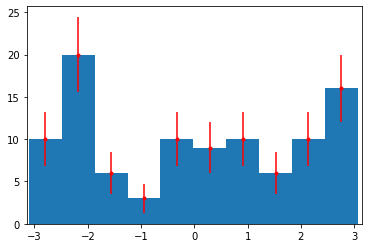

In [7]:
plot_dihedrals(dihedrals_new, os.path.join(outdir, f"correlated.png"))

### Reverse

In [8]:
indices_old = [669, 670, 673, 676]
indices_new = [669, 670, 673, 681]
dihedrals_new, dihedrals_old = get_dihedrals(i, phase, 'reverse', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:13<00:00,  7.64it/s]

old files found: 100
new files found: 100


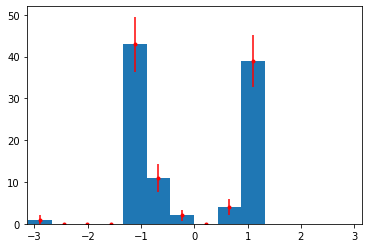

In [9]:
plot_dihedrals(dihedrals_new, os.path.join(outdir, f"correlated.png"))

# Check dihedrals of THR for complex T42A neq switching (before running annealing) 

In [17]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/31/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir))


In [18]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [19]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)>
<Atom 1 (C) of chain 0 residue 0 (ACE)>
<Atom 2 (O) of chain 0 residue 0 (ACE)>
<Atom 3 (H1) of chain 0 residue 0 (ACE)>
<Atom 4 (H2) of chain 0 residue 0 (ACE)>
<Atom 5 (H3) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (LYS)>
<Atom 7 (CA) of chain 0 residue 1 (LYS)>
<Atom 8 (C) of chain 0 residue 1 (LYS)>
<Atom 9 (O) of chain 0 residue 1 (LYS)>
<Atom 10 (CB) of chain 0 residue 1 (LYS)>
<Atom 11 (CG) of chain 0 residue 1 (LYS)>
<Atom 12 (CD) of chain 0 residue 1 (LYS)>
<Atom 13 (CE) of chain 0 residue 1 (LYS)>
<Atom 14 (NZ) of chain 0 residue 1 (LYS)>
<Atom 15 (H2) of chain 0 residue 1 (LYS)>
<Atom 16 (HA) of chain 0 residue 1 (LYS)>
<Atom 17 (HB3) of chain 0 residue 1 (LYS)>
<Atom 18 (HB2) of chain 0 residue 1 (LYS)>
<Atom 19 (HG2) of chain 0 residue 1 (LYS)>
<Atom 20 (HG3) of chain 0 residue 1 (LYS)>
<Atom 21 (HD2) of chain 0 residue 1 (LYS)>
<Atom 22 (HD3) of chain 0 residue 1 (LYS)>
<Atom 23 (HE3) of chain 0 residue 1 (LYS)>

<Atom 3570 (O) of chain 4 residue 341 (HOH)>
<Atom 3571 (H1) of chain 4 residue 341 (HOH)>
<Atom 3572 (H2) of chain 4 residue 341 (HOH)>
<Atom 3573 (O) of chain 4 residue 342 (HOH)>
<Atom 3574 (H1) of chain 4 residue 342 (HOH)>
<Atom 3575 (H2) of chain 4 residue 342 (HOH)>
<Atom 3576 (O) of chain 4 residue 343 (HOH)>
<Atom 3577 (H1) of chain 4 residue 343 (HOH)>
<Atom 3578 (H2) of chain 4 residue 343 (HOH)>
<Atom 3579 (O) of chain 4 residue 344 (HOH)>
<Atom 3580 (H1) of chain 4 residue 344 (HOH)>
<Atom 3581 (H2) of chain 4 residue 344 (HOH)>
<Atom 3582 (O) of chain 4 residue 345 (HOH)>
<Atom 3583 (H1) of chain 4 residue 345 (HOH)>
<Atom 3584 (H2) of chain 4 residue 345 (HOH)>
<Atom 3585 (O) of chain 4 residue 346 (HOH)>
<Atom 3586 (H1) of chain 4 residue 346 (HOH)>
<Atom 3587 (H2) of chain 4 residue 346 (HOH)>
<Atom 3588 (O) of chain 4 residue 347 (HOH)>
<Atom 3589 (H1) of chain 4 residue 347 (HOH)>
<Atom 3590 (H2) of chain 4 residue 347 (HOH)>
<Atom 3591 (O) of chain 4 residue 348 (HO

<Atom 7069 (H1) of chain 4 residue 1507 (HOH)>
<Atom 7070 (H2) of chain 4 residue 1507 (HOH)>
<Atom 7071 (O) of chain 4 residue 1508 (HOH)>
<Atom 7072 (H1) of chain 4 residue 1508 (HOH)>
<Atom 7073 (H2) of chain 4 residue 1508 (HOH)>
<Atom 7074 (O) of chain 4 residue 1509 (HOH)>
<Atom 7075 (H1) of chain 4 residue 1509 (HOH)>
<Atom 7076 (H2) of chain 4 residue 1509 (HOH)>
<Atom 7077 (O) of chain 4 residue 1510 (HOH)>
<Atom 7078 (H1) of chain 4 residue 1510 (HOH)>
<Atom 7079 (H2) of chain 4 residue 1510 (HOH)>
<Atom 7080 (O) of chain 4 residue 1511 (HOH)>
<Atom 7081 (H1) of chain 4 residue 1511 (HOH)>
<Atom 7082 (H2) of chain 4 residue 1511 (HOH)>
<Atom 7083 (O) of chain 4 residue 1512 (HOH)>
<Atom 7084 (H1) of chain 4 residue 1512 (HOH)>
<Atom 7085 (H2) of chain 4 residue 1512 (HOH)>
<Atom 7086 (O) of chain 4 residue 1513 (HOH)>
<Atom 7087 (H1) of chain 4 residue 1513 (HOH)>
<Atom 7088 (H2) of chain 4 residue 1513 (HOH)>
<Atom 7089 (O) of chain 4 residue 1514 (HOH)>
<Atom 7090 (H1) of c

<Atom 11069 (H2) of chain 4 residue 2840 (HOH)>
<Atom 11070 (O) of chain 4 residue 2841 (HOH)>
<Atom 11071 (H1) of chain 4 residue 2841 (HOH)>
<Atom 11072 (H2) of chain 4 residue 2841 (HOH)>
<Atom 11073 (O) of chain 4 residue 2842 (HOH)>
<Atom 11074 (H1) of chain 4 residue 2842 (HOH)>
<Atom 11075 (H2) of chain 4 residue 2842 (HOH)>
<Atom 11076 (O) of chain 4 residue 2843 (HOH)>
<Atom 11077 (H1) of chain 4 residue 2843 (HOH)>
<Atom 11078 (H2) of chain 4 residue 2843 (HOH)>
<Atom 11079 (O) of chain 4 residue 2844 (HOH)>
<Atom 11080 (H1) of chain 4 residue 2844 (HOH)>
<Atom 11081 (H2) of chain 4 residue 2844 (HOH)>
<Atom 11082 (O) of chain 4 residue 2845 (HOH)>
<Atom 11083 (H1) of chain 4 residue 2845 (HOH)>
<Atom 11084 (H2) of chain 4 residue 2845 (HOH)>
<Atom 11085 (O) of chain 4 residue 2846 (HOH)>
<Atom 11086 (H1) of chain 4 residue 2846 (HOH)>
<Atom 11087 (H2) of chain 4 residue 2846 (HOH)>
<Atom 11088 (O) of chain 4 residue 2847 (HOH)>
<Atom 11089 (H1) of chain 4 residue 2847 (HOH)>

<Atom 15068 (H2) of chain 4 residue 4173 (HOH)>
<Atom 15069 (O) of chain 4 residue 4174 (HOH)>
<Atom 15070 (H1) of chain 4 residue 4174 (HOH)>
<Atom 15071 (H2) of chain 4 residue 4174 (HOH)>
<Atom 15072 (O) of chain 4 residue 4175 (HOH)>
<Atom 15073 (H1) of chain 4 residue 4175 (HOH)>
<Atom 15074 (H2) of chain 4 residue 4175 (HOH)>
<Atom 15075 (O) of chain 4 residue 4176 (HOH)>
<Atom 15076 (H1) of chain 4 residue 4176 (HOH)>
<Atom 15077 (H2) of chain 4 residue 4176 (HOH)>
<Atom 15078 (O) of chain 4 residue 4177 (HOH)>
<Atom 15079 (H1) of chain 4 residue 4177 (HOH)>
<Atom 15080 (H2) of chain 4 residue 4177 (HOH)>
<Atom 15081 (O) of chain 4 residue 4178 (HOH)>
<Atom 15082 (H1) of chain 4 residue 4178 (HOH)>
<Atom 15083 (H2) of chain 4 residue 4178 (HOH)>
<Atom 15084 (O) of chain 4 residue 4179 (HOH)>
<Atom 15085 (H1) of chain 4 residue 4179 (HOH)>
<Atom 15086 (H2) of chain 4 residue 4179 (HOH)>
<Atom 15087 (O) of chain 4 residue 4180 (HOH)>
<Atom 15088 (H1) of chain 4 residue 4180 (HOH)>

<Atom 19068 (O) of chain 4 residue 5507 (HOH)>
<Atom 19069 (H1) of chain 4 residue 5507 (HOH)>
<Atom 19070 (H2) of chain 4 residue 5507 (HOH)>
<Atom 19071 (O) of chain 4 residue 5508 (HOH)>
<Atom 19072 (H1) of chain 4 residue 5508 (HOH)>
<Atom 19073 (H2) of chain 4 residue 5508 (HOH)>
<Atom 19074 (O) of chain 4 residue 5509 (HOH)>
<Atom 19075 (H1) of chain 4 residue 5509 (HOH)>
<Atom 19076 (H2) of chain 4 residue 5509 (HOH)>
<Atom 19077 (O) of chain 4 residue 5510 (HOH)>
<Atom 19078 (H1) of chain 4 residue 5510 (HOH)>
<Atom 19079 (H2) of chain 4 residue 5510 (HOH)>
<Atom 19080 (O) of chain 4 residue 5511 (HOH)>
<Atom 19081 (H1) of chain 4 residue 5511 (HOH)>
<Atom 19082 (H2) of chain 4 residue 5511 (HOH)>
<Atom 19083 (O) of chain 4 residue 5512 (HOH)>
<Atom 19084 (H1) of chain 4 residue 5512 (HOH)>
<Atom 19085 (H2) of chain 4 residue 5512 (HOH)>
<Atom 19086 (O) of chain 4 residue 5513 (HOH)>
<Atom 19087 (H1) of chain 4 residue 5513 (HOH)>
<Atom 19088 (H2) of chain 4 residue 5513 (HOH)>

<Atom 23067 (O) of chain 4 residue 6840 (HOH)>
<Atom 23068 (H1) of chain 4 residue 6840 (HOH)>
<Atom 23069 (H2) of chain 4 residue 6840 (HOH)>
<Atom 23070 (O) of chain 4 residue 6841 (HOH)>
<Atom 23071 (H1) of chain 4 residue 6841 (HOH)>
<Atom 23072 (H2) of chain 4 residue 6841 (HOH)>
<Atom 23073 (O) of chain 4 residue 6842 (HOH)>
<Atom 23074 (H1) of chain 4 residue 6842 (HOH)>
<Atom 23075 (H2) of chain 4 residue 6842 (HOH)>
<Atom 23076 (O) of chain 4 residue 6843 (HOH)>
<Atom 23077 (H1) of chain 4 residue 6843 (HOH)>
<Atom 23078 (H2) of chain 4 residue 6843 (HOH)>
<Atom 23079 (O) of chain 4 residue 6844 (HOH)>
<Atom 23080 (H1) of chain 4 residue 6844 (HOH)>
<Atom 23081 (H2) of chain 4 residue 6844 (HOH)>
<Atom 23082 (O) of chain 4 residue 6845 (HOH)>
<Atom 23083 (H1) of chain 4 residue 6845 (HOH)>
<Atom 23084 (H2) of chain 4 residue 6845 (HOH)>
<Atom 23085 (O) of chain 4 residue 6846 (HOH)>
<Atom 23086 (H1) of chain 4 residue 6846 (HOH)>
<Atom 23087 (H2) of chain 4 residue 6846 (HOH)>

<Atom 27067 (H1) of chain 4 residue 8173 (HOH)>
<Atom 27068 (H2) of chain 4 residue 8173 (HOH)>
<Atom 27069 (O) of chain 4 residue 8174 (HOH)>
<Atom 27070 (H1) of chain 4 residue 8174 (HOH)>
<Atom 27071 (H2) of chain 4 residue 8174 (HOH)>
<Atom 27072 (O) of chain 4 residue 8175 (HOH)>
<Atom 27073 (H1) of chain 4 residue 8175 (HOH)>
<Atom 27074 (H2) of chain 4 residue 8175 (HOH)>
<Atom 27075 (O) of chain 4 residue 8176 (HOH)>
<Atom 27076 (H1) of chain 4 residue 8176 (HOH)>
<Atom 27077 (H2) of chain 4 residue 8176 (HOH)>
<Atom 27078 (O) of chain 4 residue 8177 (HOH)>
<Atom 27079 (H1) of chain 4 residue 8177 (HOH)>
<Atom 27080 (H2) of chain 4 residue 8177 (HOH)>
<Atom 27081 (O) of chain 4 residue 8178 (HOH)>
<Atom 27082 (H1) of chain 4 residue 8178 (HOH)>
<Atom 27083 (H2) of chain 4 residue 8178 (HOH)>
<Atom 27084 (O) of chain 4 residue 8179 (HOH)>
<Atom 27085 (H1) of chain 4 residue 8179 (HOH)>
<Atom 27086 (H2) of chain 4 residue 8179 (HOH)>
<Atom 27087 (O) of chain 4 residue 8180 (HOH)>

### Forward

In [20]:
indices_old = [669, 670, 673, 674]
indices_new = [669, 670, 673, 676]
dihedrals_new, dihedrals_old = get_dihedrals(i, phase, 'forward', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:09<00:00, 10.46it/s]

old files found: 83
new files found: 83


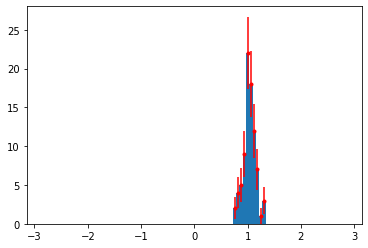

In [21]:
plot_dihedrals(dihedrals_old, os.path.join(outdir, f"correlated.png"))


### Reverse

In [22]:
indices_old = [669, 670, 673, 674]
indices_new = [669, 670, 673, 676]
dihedrals_new, dihedrals_old = get_dihedrals(i, phase, 'reverse', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:09<00:00, 10.84it/s]

old files found: 83
new files found: 83


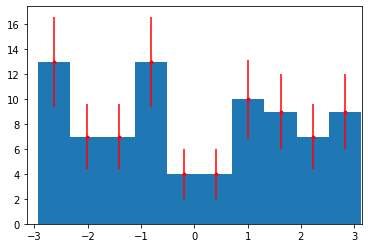

In [23]:
plot_dihedrals(dihedrals_old, os.path.join(outdir, f"correlated.png"))


# Check dihedrals of THR for complex A42T neq switching (before running annealing) 

In [10]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/32/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir))


In [11]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [26]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)>
<Atom 1 (C) of chain 0 residue 0 (ACE)>
<Atom 2 (O) of chain 0 residue 0 (ACE)>
<Atom 3 (H1) of chain 0 residue 0 (ACE)>
<Atom 4 (H2) of chain 0 residue 0 (ACE)>
<Atom 5 (H3) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (LYS)>
<Atom 7 (CA) of chain 0 residue 1 (LYS)>
<Atom 8 (C) of chain 0 residue 1 (LYS)>
<Atom 9 (O) of chain 0 residue 1 (LYS)>
<Atom 10 (CB) of chain 0 residue 1 (LYS)>
<Atom 11 (CG) of chain 0 residue 1 (LYS)>
<Atom 12 (CD) of chain 0 residue 1 (LYS)>
<Atom 13 (CE) of chain 0 residue 1 (LYS)>
<Atom 14 (NZ) of chain 0 residue 1 (LYS)>
<Atom 15 (H2) of chain 0 residue 1 (LYS)>
<Atom 16 (HA) of chain 0 residue 1 (LYS)>
<Atom 17 (HB3) of chain 0 residue 1 (LYS)>
<Atom 18 (HB2) of chain 0 residue 1 (LYS)>
<Atom 19 (HG2) of chain 0 residue 1 (LYS)>
<Atom 20 (HG3) of chain 0 residue 1 (LYS)>
<Atom 21 (HD2) of chain 0 residue 1 (LYS)>
<Atom 22 (HD3) of chain 0 residue 1 (LYS)>
<Atom 23 (HE3) of chain 0 residue 1 (LYS)>

<Atom 3320 (H2) of chain 2 residue 718 (HOH)>
<Atom 3321 (O) of chain 2 residue 719 (HOH)>
<Atom 3322 (H1) of chain 2 residue 719 (HOH)>
<Atom 3323 (H2) of chain 2 residue 719 (HOH)>
<Atom 3324 (O) of chain 2 residue 720 (HOH)>
<Atom 3325 (H1) of chain 2 residue 720 (HOH)>
<Atom 3326 (H2) of chain 2 residue 720 (HOH)>
<Atom 3327 (O) of chain 2 residue 721 (HOH)>
<Atom 3328 (H1) of chain 2 residue 721 (HOH)>
<Atom 3329 (H2) of chain 2 residue 721 (HOH)>
<Atom 3330 (O) of chain 2 residue 722 (HOH)>
<Atom 3331 (H1) of chain 2 residue 722 (HOH)>
<Atom 3332 (H2) of chain 2 residue 722 (HOH)>
<Atom 3333 (O) of chain 2 residue 723 (HOH)>
<Atom 3334 (H1) of chain 2 residue 723 (HOH)>
<Atom 3335 (H2) of chain 2 residue 723 (HOH)>
<Atom 3336 (O) of chain 2 residue 724 (HOH)>
<Atom 3337 (H1) of chain 2 residue 724 (HOH)>
<Atom 3338 (H2) of chain 2 residue 724 (HOH)>
<Atom 3339 (O) of chain 2 residue 725 (HOH)>
<Atom 3340 (H1) of chain 2 residue 725 (HOH)>
<Atom 3341 (H2) of chain 2 residue 725 (H

<Atom 6820 (H1) of chain 2 residue 1885 (HOH)>
<Atom 6821 (H2) of chain 2 residue 1885 (HOH)>
<Atom 6822 (O) of chain 2 residue 1886 (HOH)>
<Atom 6823 (H1) of chain 2 residue 1886 (HOH)>
<Atom 6824 (H2) of chain 2 residue 1886 (HOH)>
<Atom 6825 (O) of chain 2 residue 1887 (HOH)>
<Atom 6826 (H1) of chain 2 residue 1887 (HOH)>
<Atom 6827 (H2) of chain 2 residue 1887 (HOH)>
<Atom 6828 (O) of chain 2 residue 1888 (HOH)>
<Atom 6829 (H1) of chain 2 residue 1888 (HOH)>
<Atom 6830 (H2) of chain 2 residue 1888 (HOH)>
<Atom 6831 (O) of chain 2 residue 1889 (HOH)>
<Atom 6832 (H1) of chain 2 residue 1889 (HOH)>
<Atom 6833 (H2) of chain 2 residue 1889 (HOH)>
<Atom 6834 (O) of chain 2 residue 1890 (HOH)>
<Atom 6835 (H1) of chain 2 residue 1890 (HOH)>
<Atom 6836 (H2) of chain 2 residue 1890 (HOH)>
<Atom 6837 (O) of chain 2 residue 1891 (HOH)>
<Atom 6838 (H1) of chain 2 residue 1891 (HOH)>
<Atom 6839 (H2) of chain 2 residue 1891 (HOH)>
<Atom 6840 (O) of chain 2 residue 1892 (HOH)>
<Atom 6841 (H1) of c

<Atom 10319 (H2) of chain 2 residue 3051 (HOH)>
<Atom 10320 (O) of chain 2 residue 3052 (HOH)>
<Atom 10321 (H1) of chain 2 residue 3052 (HOH)>
<Atom 10322 (H2) of chain 2 residue 3052 (HOH)>
<Atom 10323 (O) of chain 2 residue 3053 (HOH)>
<Atom 10324 (H1) of chain 2 residue 3053 (HOH)>
<Atom 10325 (H2) of chain 2 residue 3053 (HOH)>
<Atom 10326 (O) of chain 2 residue 3054 (HOH)>
<Atom 10327 (H1) of chain 2 residue 3054 (HOH)>
<Atom 10328 (H2) of chain 2 residue 3054 (HOH)>
<Atom 10329 (O) of chain 2 residue 3055 (HOH)>
<Atom 10330 (H1) of chain 2 residue 3055 (HOH)>
<Atom 10331 (H2) of chain 2 residue 3055 (HOH)>
<Atom 10332 (O) of chain 2 residue 3056 (HOH)>
<Atom 10333 (H1) of chain 2 residue 3056 (HOH)>
<Atom 10334 (H2) of chain 2 residue 3056 (HOH)>
<Atom 10335 (O) of chain 2 residue 3057 (HOH)>
<Atom 10336 (H1) of chain 2 residue 3057 (HOH)>
<Atom 10337 (H2) of chain 2 residue 3057 (HOH)>
<Atom 10338 (O) of chain 2 residue 3058 (HOH)>
<Atom 10339 (H1) of chain 2 residue 3058 (HOH)>

<Atom 14319 (O) of chain 2 residue 4385 (HOH)>
<Atom 14320 (H1) of chain 2 residue 4385 (HOH)>
<Atom 14321 (H2) of chain 2 residue 4385 (HOH)>
<Atom 14322 (O) of chain 2 residue 4386 (HOH)>
<Atom 14323 (H1) of chain 2 residue 4386 (HOH)>
<Atom 14324 (H2) of chain 2 residue 4386 (HOH)>
<Atom 14325 (O) of chain 2 residue 4387 (HOH)>
<Atom 14326 (H1) of chain 2 residue 4387 (HOH)>
<Atom 14327 (H2) of chain 2 residue 4387 (HOH)>
<Atom 14328 (O) of chain 2 residue 4388 (HOH)>
<Atom 14329 (H1) of chain 2 residue 4388 (HOH)>
<Atom 14330 (H2) of chain 2 residue 4388 (HOH)>
<Atom 14331 (O) of chain 2 residue 4389 (HOH)>
<Atom 14332 (H1) of chain 2 residue 4389 (HOH)>
<Atom 14333 (H2) of chain 2 residue 4389 (HOH)>
<Atom 14334 (O) of chain 2 residue 4390 (HOH)>
<Atom 14335 (H1) of chain 2 residue 4390 (HOH)>
<Atom 14336 (H2) of chain 2 residue 4390 (HOH)>
<Atom 14337 (O) of chain 2 residue 4391 (HOH)>
<Atom 14338 (H1) of chain 2 residue 4391 (HOH)>
<Atom 14339 (H2) of chain 2 residue 4391 (HOH)>

### Forward

In [12]:
indices_old = [669, 670, 673, 676]
indices_new = [669, 670, 673, 681]
dihedrals_new, dihedrals_old = get_dihedrals(i, phase, 'forward', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


old files found: 86
new files found: 86


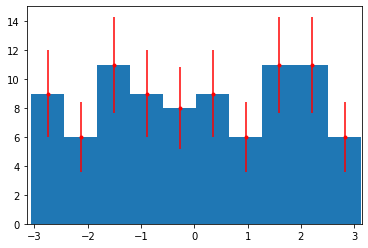

In [13]:
plot_dihedrals(dihedrals_new, os.path.join(outdir, f"correlated.png"))

### Reverse

In [14]:
indices_old = [669, 670, 673, 676]
indices_new = [669, 670, 673, 681]
dihedrals_new, dihedrals_old = get_dihedrals(i, phase, 'reverse', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


old files found: 86
new files found: 86


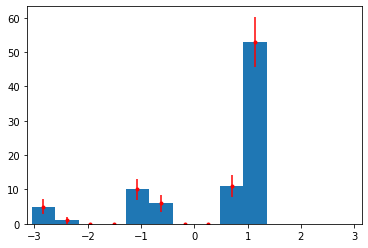

In [15]:
plot_dihedrals(dihedrals_new, os.path.join(outdir, f"correlated.png"))


# Check dihedrals of ALA for apo A42T neq switching (before running annealing) 

In [47]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/32/"
phase = "apo"
i = os.path.basename(os.path.dirname(outdir))


In [48]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [49]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)>
<Atom 1 (C) of chain 0 residue 0 (ACE)>
<Atom 2 (O) of chain 0 residue 0 (ACE)>
<Atom 3 (H1) of chain 0 residue 0 (ACE)>
<Atom 4 (H2) of chain 0 residue 0 (ACE)>
<Atom 5 (H3) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (LYS)>
<Atom 7 (CA) of chain 0 residue 1 (LYS)>
<Atom 8 (C) of chain 0 residue 1 (LYS)>
<Atom 9 (O) of chain 0 residue 1 (LYS)>
<Atom 10 (CB) of chain 0 residue 1 (LYS)>
<Atom 11 (CG) of chain 0 residue 1 (LYS)>
<Atom 12 (CD) of chain 0 residue 1 (LYS)>
<Atom 13 (CE) of chain 0 residue 1 (LYS)>
<Atom 14 (NZ) of chain 0 residue 1 (LYS)>
<Atom 15 (H2) of chain 0 residue 1 (LYS)>
<Atom 16 (HA) of chain 0 residue 1 (LYS)>
<Atom 17 (HB3) of chain 0 residue 1 (LYS)>
<Atom 18 (HB2) of chain 0 residue 1 (LYS)>
<Atom 19 (HG2) of chain 0 residue 1 (LYS)>
<Atom 20 (HG3) of chain 0 residue 1 (LYS)>
<Atom 21 (HD2) of chain 0 residue 1 (LYS)>
<Atom 22 (HD3) of chain 0 residue 1 (LYS)>
<Atom 23 (HE3) of chain 0 residue 1 (LYS)>

<Atom 3416 (H2) of chain 2 residue 750 (HOH)>
<Atom 3417 (O) of chain 2 residue 751 (HOH)>
<Atom 3418 (H1) of chain 2 residue 751 (HOH)>
<Atom 3419 (H2) of chain 2 residue 751 (HOH)>
<Atom 3420 (O) of chain 2 residue 752 (HOH)>
<Atom 3421 (H1) of chain 2 residue 752 (HOH)>
<Atom 3422 (H2) of chain 2 residue 752 (HOH)>
<Atom 3423 (O) of chain 2 residue 753 (HOH)>
<Atom 3424 (H1) of chain 2 residue 753 (HOH)>
<Atom 3425 (H2) of chain 2 residue 753 (HOH)>
<Atom 3426 (O) of chain 2 residue 754 (HOH)>
<Atom 3427 (H1) of chain 2 residue 754 (HOH)>
<Atom 3428 (H2) of chain 2 residue 754 (HOH)>
<Atom 3429 (O) of chain 2 residue 755 (HOH)>
<Atom 3430 (H1) of chain 2 residue 755 (HOH)>
<Atom 3431 (H2) of chain 2 residue 755 (HOH)>
<Atom 3432 (O) of chain 2 residue 756 (HOH)>
<Atom 3433 (H1) of chain 2 residue 756 (HOH)>
<Atom 3434 (H2) of chain 2 residue 756 (HOH)>
<Atom 3435 (O) of chain 2 residue 757 (HOH)>
<Atom 3436 (H1) of chain 2 residue 757 (HOH)>
<Atom 3437 (H2) of chain 2 residue 757 (H

<Atom 6915 (O) of chain 2 residue 1917 (HOH)>
<Atom 6916 (H1) of chain 2 residue 1917 (HOH)>
<Atom 6917 (H2) of chain 2 residue 1917 (HOH)>
<Atom 6918 (O) of chain 2 residue 1918 (HOH)>
<Atom 6919 (H1) of chain 2 residue 1918 (HOH)>
<Atom 6920 (H2) of chain 2 residue 1918 (HOH)>
<Atom 6921 (O) of chain 2 residue 1919 (HOH)>
<Atom 6922 (H1) of chain 2 residue 1919 (HOH)>
<Atom 6923 (H2) of chain 2 residue 1919 (HOH)>
<Atom 6924 (O) of chain 2 residue 1920 (HOH)>
<Atom 6925 (H1) of chain 2 residue 1920 (HOH)>
<Atom 6926 (H2) of chain 2 residue 1920 (HOH)>
<Atom 6927 (O) of chain 2 residue 1921 (HOH)>
<Atom 6928 (H1) of chain 2 residue 1921 (HOH)>
<Atom 6929 (H2) of chain 2 residue 1921 (HOH)>
<Atom 6930 (O) of chain 2 residue 1922 (HOH)>
<Atom 6931 (H1) of chain 2 residue 1922 (HOH)>
<Atom 6932 (H2) of chain 2 residue 1922 (HOH)>
<Atom 6933 (O) of chain 2 residue 1923 (HOH)>
<Atom 6934 (H1) of chain 2 residue 1923 (HOH)>
<Atom 6935 (H2) of chain 2 residue 1923 (HOH)>
<Atom 6936 (O) of ch

<Atom 10415 (H2) of chain 2 residue 3083 (HOH)>
<Atom 10416 (O) of chain 2 residue 3084 (HOH)>
<Atom 10417 (H1) of chain 2 residue 3084 (HOH)>
<Atom 10418 (H2) of chain 2 residue 3084 (HOH)>
<Atom 10419 (O) of chain 2 residue 3085 (HOH)>
<Atom 10420 (H1) of chain 2 residue 3085 (HOH)>
<Atom 10421 (H2) of chain 2 residue 3085 (HOH)>
<Atom 10422 (O) of chain 2 residue 3086 (HOH)>
<Atom 10423 (H1) of chain 2 residue 3086 (HOH)>
<Atom 10424 (H2) of chain 2 residue 3086 (HOH)>
<Atom 10425 (O) of chain 2 residue 3087 (HOH)>
<Atom 10426 (H1) of chain 2 residue 3087 (HOH)>
<Atom 10427 (H2) of chain 2 residue 3087 (HOH)>
<Atom 10428 (O) of chain 2 residue 3088 (HOH)>
<Atom 10429 (H1) of chain 2 residue 3088 (HOH)>
<Atom 10430 (H2) of chain 2 residue 3088 (HOH)>
<Atom 10431 (O) of chain 2 residue 3089 (HOH)>
<Atom 10432 (H1) of chain 2 residue 3089 (HOH)>
<Atom 10433 (H2) of chain 2 residue 3089 (HOH)>
<Atom 10434 (O) of chain 2 residue 3090 (HOH)>
<Atom 10435 (H1) of chain 2 residue 3090 (HOH)>

<Atom 14414 (H2) of chain 2 residue 4416 (HOH)>
<Atom 14415 (O) of chain 2 residue 4417 (HOH)>
<Atom 14416 (H1) of chain 2 residue 4417 (HOH)>
<Atom 14417 (H2) of chain 2 residue 4417 (HOH)>
<Atom 14418 (O) of chain 2 residue 4418 (HOH)>
<Atom 14419 (H1) of chain 2 residue 4418 (HOH)>
<Atom 14420 (H2) of chain 2 residue 4418 (HOH)>
<Atom 14421 (O) of chain 2 residue 4419 (HOH)>
<Atom 14422 (H1) of chain 2 residue 4419 (HOH)>
<Atom 14423 (H2) of chain 2 residue 4419 (HOH)>
<Atom 14424 (O) of chain 2 residue 4420 (HOH)>
<Atom 14425 (H1) of chain 2 residue 4420 (HOH)>
<Atom 14426 (H2) of chain 2 residue 4420 (HOH)>
<Atom 14427 (O) of chain 2 residue 4421 (HOH)>
<Atom 14428 (H1) of chain 2 residue 4421 (HOH)>
<Atom 14429 (H2) of chain 2 residue 4421 (HOH)>
<Atom 14430 (O) of chain 2 residue 4422 (HOH)>
<Atom 14431 (H1) of chain 2 residue 4422 (HOH)>
<Atom 14432 (H2) of chain 2 residue 4422 (HOH)>
<Atom 14433 (O) of chain 2 residue 4423 (HOH)>
<Atom 14434 (H1) of chain 2 residue 4423 (HOH)>

### Forward

In [50]:
indices_old = [669, 670, 673, 676]
indices_new = [669, 670, 673, 674]
dihedrals_new, dihedrals_old = get_dihedrals(i, phase, 'forward', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]

old files found: 100
new files found: 100


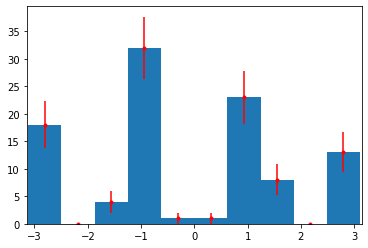

In [51]:
plot_dihedrals(dihedrals_old, os.path.join(outdir, f"correlated.png"))

### Reverse

In [52]:
indices_old = [669, 670, 673, 676]
indices_new = [669, 670, 673, 674]
dihedrals_new, dihedrals_old = get_dihedrals(i, phase, 'reverse', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]

old files found: 100
new files found: 100


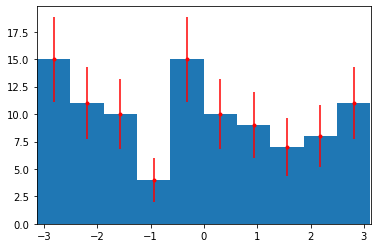

In [53]:
plot_dihedrals(dihedrals_old, os.path.join(outdir, f"correlated.png"))

# Check dihedrals of off THR @ lambda = 0 for apo A42T vanilla MD

In [2]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/32/"
phase = "apo"
i = os.path.basename(os.path.dirname(outdir))


In [3]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [4]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)>
<Atom 1 (C) of chain 0 residue 0 (ACE)>
<Atom 2 (O) of chain 0 residue 0 (ACE)>
<Atom 3 (H1) of chain 0 residue 0 (ACE)>
<Atom 4 (H2) of chain 0 residue 0 (ACE)>
<Atom 5 (H3) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (LYS)>
<Atom 7 (CA) of chain 0 residue 1 (LYS)>
<Atom 8 (C) of chain 0 residue 1 (LYS)>
<Atom 9 (O) of chain 0 residue 1 (LYS)>
<Atom 10 (CB) of chain 0 residue 1 (LYS)>
<Atom 11 (CG) of chain 0 residue 1 (LYS)>
<Atom 12 (CD) of chain 0 residue 1 (LYS)>
<Atom 13 (CE) of chain 0 residue 1 (LYS)>
<Atom 14 (NZ) of chain 0 residue 1 (LYS)>
<Atom 15 (H2) of chain 0 residue 1 (LYS)>
<Atom 16 (HA) of chain 0 residue 1 (LYS)>
<Atom 17 (HB3) of chain 0 residue 1 (LYS)>
<Atom 18 (HB2) of chain 0 residue 1 (LYS)>
<Atom 19 (HG2) of chain 0 residue 1 (LYS)>
<Atom 20 (HG3) of chain 0 residue 1 (LYS)>
<Atom 21 (HD2) of chain 0 residue 1 (LYS)>
<Atom 22 (HD3) of chain 0 residue 1 (LYS)>
<Atom 23 (HE3) of chain 0 residue 1 (LYS)>

<Atom 3469 (H1) of chain 2 residue 768 (HOH)>
<Atom 3470 (H2) of chain 2 residue 768 (HOH)>
<Atom 3471 (O) of chain 2 residue 769 (HOH)>
<Atom 3472 (H1) of chain 2 residue 769 (HOH)>
<Atom 3473 (H2) of chain 2 residue 769 (HOH)>
<Atom 3474 (O) of chain 2 residue 770 (HOH)>
<Atom 3475 (H1) of chain 2 residue 770 (HOH)>
<Atom 3476 (H2) of chain 2 residue 770 (HOH)>
<Atom 3477 (O) of chain 2 residue 771 (HOH)>
<Atom 3478 (H1) of chain 2 residue 771 (HOH)>
<Atom 3479 (H2) of chain 2 residue 771 (HOH)>
<Atom 3480 (O) of chain 2 residue 772 (HOH)>
<Atom 3481 (H1) of chain 2 residue 772 (HOH)>
<Atom 3482 (H2) of chain 2 residue 772 (HOH)>
<Atom 3483 (O) of chain 2 residue 773 (HOH)>
<Atom 3484 (H1) of chain 2 residue 773 (HOH)>
<Atom 3485 (H2) of chain 2 residue 773 (HOH)>
<Atom 3486 (O) of chain 2 residue 774 (HOH)>
<Atom 3487 (H1) of chain 2 residue 774 (HOH)>
<Atom 3488 (H2) of chain 2 residue 774 (HOH)>
<Atom 3489 (O) of chain 2 residue 775 (HOH)>
<Atom 3490 (H1) of chain 2 residue 775 (H

<Atom 6968 (H2) of chain 2 residue 1934 (HOH)>
<Atom 6969 (O) of chain 2 residue 1935 (HOH)>
<Atom 6970 (H1) of chain 2 residue 1935 (HOH)>
<Atom 6971 (H2) of chain 2 residue 1935 (HOH)>
<Atom 6972 (O) of chain 2 residue 1936 (HOH)>
<Atom 6973 (H1) of chain 2 residue 1936 (HOH)>
<Atom 6974 (H2) of chain 2 residue 1936 (HOH)>
<Atom 6975 (O) of chain 2 residue 1937 (HOH)>
<Atom 6976 (H1) of chain 2 residue 1937 (HOH)>
<Atom 6977 (H2) of chain 2 residue 1937 (HOH)>
<Atom 6978 (O) of chain 2 residue 1938 (HOH)>
<Atom 6979 (H1) of chain 2 residue 1938 (HOH)>
<Atom 6980 (H2) of chain 2 residue 1938 (HOH)>
<Atom 6981 (O) of chain 2 residue 1939 (HOH)>
<Atom 6982 (H1) of chain 2 residue 1939 (HOH)>
<Atom 6983 (H2) of chain 2 residue 1939 (HOH)>
<Atom 6984 (O) of chain 2 residue 1940 (HOH)>
<Atom 6985 (H1) of chain 2 residue 1940 (HOH)>
<Atom 6986 (H2) of chain 2 residue 1940 (HOH)>
<Atom 6987 (O) of chain 2 residue 1941 (HOH)>
<Atom 6988 (H1) of chain 2 residue 1941 (HOH)>
<Atom 6989 (H2) of c

<Atom 10468 (H1) of chain 2 residue 3101 (HOH)>
<Atom 10469 (H2) of chain 2 residue 3101 (HOH)>
<Atom 10470 (O) of chain 2 residue 3102 (HOH)>
<Atom 10471 (H1) of chain 2 residue 3102 (HOH)>
<Atom 10472 (H2) of chain 2 residue 3102 (HOH)>
<Atom 10473 (O) of chain 2 residue 3103 (HOH)>
<Atom 10474 (H1) of chain 2 residue 3103 (HOH)>
<Atom 10475 (H2) of chain 2 residue 3103 (HOH)>
<Atom 10476 (O) of chain 2 residue 3104 (HOH)>
<Atom 10477 (H1) of chain 2 residue 3104 (HOH)>
<Atom 10478 (H2) of chain 2 residue 3104 (HOH)>
<Atom 10479 (O) of chain 2 residue 3105 (HOH)>
<Atom 10480 (H1) of chain 2 residue 3105 (HOH)>
<Atom 10481 (H2) of chain 2 residue 3105 (HOH)>
<Atom 10482 (O) of chain 2 residue 3106 (HOH)>
<Atom 10483 (H1) of chain 2 residue 3106 (HOH)>
<Atom 10484 (H2) of chain 2 residue 3106 (HOH)>
<Atom 10485 (O) of chain 2 residue 3107 (HOH)>
<Atom 10486 (H1) of chain 2 residue 3107 (HOH)>
<Atom 10487 (H2) of chain 2 residue 3107 (HOH)>
<Atom 10488 (O) of chain 2 residue 3108 (HOH)>

<Atom 14467 (H1) of chain 2 residue 4434 (HOH)>
<Atom 14468 (H2) of chain 2 residue 4434 (HOH)>
<Atom 14469 (O) of chain 2 residue 4435 (HOH)>
<Atom 14470 (H1) of chain 2 residue 4435 (HOH)>
<Atom 14471 (H2) of chain 2 residue 4435 (HOH)>
<Atom 14472 (O) of chain 2 residue 4436 (HOH)>
<Atom 14473 (H1) of chain 2 residue 4436 (HOH)>
<Atom 14474 (H2) of chain 2 residue 4436 (HOH)>
<Atom 14475 (O) of chain 2 residue 4437 (HOH)>
<Atom 14476 (H1) of chain 2 residue 4437 (HOH)>
<Atom 14477 (H2) of chain 2 residue 4437 (HOH)>
<Atom 14478 (O) of chain 2 residue 4438 (HOH)>
<Atom 14479 (H1) of chain 2 residue 4438 (HOH)>
<Atom 14480 (H2) of chain 2 residue 4438 (HOH)>
<Atom 14481 (O) of chain 2 residue 4439 (HOH)>
<Atom 14482 (H1) of chain 2 residue 4439 (HOH)>
<Atom 14483 (H2) of chain 2 residue 4439 (HOH)>
<Atom 14484 (O) of chain 2 residue 4440 (HOH)>
<Atom 14485 (H1) of chain 2 residue 4440 (HOH)>
<Atom 14486 (H2) of chain 2 residue 4440 (HOH)>
<Atom 14487 (O) of chain 2 residue 4441 (HOH)>

In [23]:
indices_old = [669, 670, 673, 676]
indices_new = [669, 670, 673, 674]
dihedrals_new, dihedrals_old = get_dihedrals_from_hybrid(i, phase, 0, outdir, htf, indices_new, indices_old)                                       


100%|██████████| 2501/2501 [08:14<00:00,  5.06it/s]


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

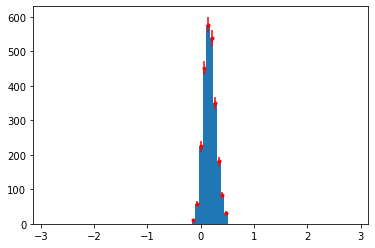

In [24]:
plot_dihedrals(dihedrals_new, os.path.join(outdir, f"correlated.png"))

In [25]:
with open(os.path.join(outdir, "32_apo_equil_hybrid_0_20ns_dihedrals_new.npy"), "wb") as f:
    np.save(f, dihedrals_new)

In [26]:
with open(os.path.join(outdir, "32_apo_equil_hybrid_0_20ns_dihedrals_old.npy"), "wb") as f:
    np.save(f, dihedrals_old)